In [1]:
import numpy as np

In [2]:
def extractPoseHand(npy):
    np_matrix=npy.reshape(-1,1629)
    # arr = []
    # print(np_matrix.shape)
    pose  = np_matrix[: ,0:99]
    hands  = np_matrix[: ,1503:1629]
    
 
    arr = np.concatenate((pose, hands), axis=1)


      
    return arr

In [3]:
import random
import os
import numpy as np

crossValidationDataPaths=['NORMALIZED/NumericalData/ML/Training/RightHand','NORMALIZED/NumericalData/ML/Training/LeftHand']
testPaths=['NORMALIZED/NumericalData/ML/Test/RightHand','NORMALIZED/NumericalData/ML/Test/LeftHand']



ml_instances_paths=[]
for path in crossValidationDataPaths:
    #print(path)
    classFolders= os.listdir(path)
    for classFolder in classFolders:
        classFolder_path=f'{path}/{classFolder}'
        classTrials =os.listdir(classFolder_path)
        for trial in classTrials:
            trialPath =f'{classFolder_path}/{trial}'
            #print(trialPath)
            ml_instances_paths.append(trialPath)
            


#randomize the list
random.shuffle(ml_instances_paths)



x_shape =[]
y_shape =[]
for ml_instances_path in ml_instances_paths:
    label = ml_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    y_shape.append(int(label))
    npy =np.load(ml_instances_path)
    npy = npy*100
  
    # npy_matrix=npy.reshape(-1,1629)
   
    npy_matrix=extractPoseHand(npy)
    x_shape.append(npy_matrix)    

test_instances_paths=[]
for path in testPaths:
    #print(path)
    testFolders= os.listdir(path)
    for testFolder in testFolders:
        testFolder_path=f'{path}/{testFolder}'
        testTrials =os.listdir(testFolder_path)
        for trial in testTrials:
            trialPath =f'{testFolder_path}/{trial}'
            #print(trialPath)
            test_instances_paths.append(trialPath)


test_x_shape =[]
test_y_shape =[]
for test_instances_path in test_instances_paths:
    label = test_instances_path.split('/')
    label = label[len(label)-1].split('_')[0]
    #print(label)
    test_y_shape.append(int(label))
    npy =np.load(test_instances_path)
    npy=npy*100
    # npy_matrix=npy.reshape(-1,1629)

    npy_matrix=extractPoseHand(npy)
    
    test_x_shape.append(npy_matrix)    


In [4]:
# training the total data
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Bidirectional, LSTM, Flatten, Dense,Input,  Dropout, BatchNormalization, GRU, Attention,Concatenate, Conv1D, Masking, Embedding
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.optimizers import Adam
import os

epochs = 200
batch_size = 32
NO_CLASSES = 60 #Changes according to no of class
MAX_FRMAE = 164

learning_rate = 0.00003
input_shape = (MAX_FRMAE,225) # pose hands



log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

print(y_shape)
#y_onehot = to_categorical(y_shape).astype(int)
label_encoder=LabelEncoder()
y_encoded =label_encoder.fit_transform(y_shape)
y_onehot =to_categorical(y_encoded,num_classes=NO_CLASSES)
print(len(y_onehot))



all_accuracies = []
x_shapeML = np.array(x_shape) #.astype(int)
x_train=x_shapeML
y_train =y_onehot

test_x_shapeML = np.array(test_x_shape) #.astype(int)
x_val=test_x_shapeML

#y_val = to_categorical(test_y_shape).astype(int)
y_encoded =label_encoder.fit_transform(test_y_shape)
y_val =to_categorical(y_encoded,num_classes=NO_CLASSES)


print('Train shape: ',x_train.shape, y_train.shape,'Test Shape: ', x_val.shape, y_val.shape)

2024-01-05 11:00:47.246845: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-05 11:00:47.267529: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-05 11:00:47.267548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-05 11:00:47.268115: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-05 11:00:47.271602: I tensorflow/core/platform/cpu_feature_guar

[27, 53, 44, 51, 42, 58, 50, 18, 7, 50, 41, 21, 4, 0, 4, 1, 36, 7, 3, 55, 33, 56, 48, 19, 32, 16, 42, 31, 1, 9, 40, 56, 10, 13, 25, 20, 23, 21, 58, 35, 52, 52, 1, 8, 57, 4, 40, 1, 40, 10, 4, 44, 42, 57, 58, 35, 54, 48, 0, 41, 8, 29, 42, 42, 0, 50, 59, 24, 1, 4, 58, 40, 48, 58, 14, 3, 54, 34, 26, 56, 16, 27, 42, 57, 46, 24, 17, 51, 17, 42, 27, 1, 18, 8, 19, 30, 4, 53, 14, 11, 13, 48, 17, 23, 50, 13, 28, 26, 36, 58, 30, 3, 7, 24, 51, 8, 39, 42, 56, 55, 27, 19, 39, 25, 5, 49, 7, 5, 25, 5, 13, 49, 24, 35, 1, 58, 22, 57, 1, 48, 52, 15, 47, 4, 23, 0, 19, 23, 55, 13, 1, 45, 51, 16, 32, 45, 8, 36, 58, 48, 14, 4, 21, 19, 11, 54, 29, 53, 59, 14, 36, 5, 55, 59, 57, 51, 48, 1, 44, 37, 39, 30, 34, 46, 12, 12, 40, 2, 18, 27, 21, 12, 37, 46, 52, 56, 53, 10, 2, 17, 49, 48, 59, 29, 35, 0, 8, 5, 40, 58, 22, 12, 7, 29, 32, 20, 53, 37, 47, 4, 52, 13, 53, 4, 50, 24, 37, 57, 43, 53, 33, 57, 7, 15, 44, 9, 55, 52, 17, 38, 18, 26, 7, 58, 18, 33, 57, 18, 13, 6, 15, 9, 20, 46, 11, 51, 28, 19, 31, 18, 37, 31, 52,

In [5]:


# Define and compile the model


num_folds = 10
# Train the model
kfold = KFold(n_splits=num_folds, shuffle=True)


i = 1

all_accuracies = []
test_accuracies = []
conf_matrixes = []
bestTestAccuracy=0
bestTest=0

for train, test in kfold.split(x_train, y_train):

    input = Input(shape=input_shape)
    bd1 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bn1 = BatchNormalization()(bd1)
    bd11 = Dropout(0.3)(bd1)

    bd2 = Bidirectional(LSTM(units=64, return_sequences=True))(input)
    # bd22 = BatchNormalization()(bd2)

    att = Attention(use_scale=True)([bd2, bd11])

    merged = Concatenate(axis=-1)([bd2, att])

    flat = Flatten()(merged)
    dense = Dense(units=64, activation='silu')(flat)
    dp2 = Dropout(0.3)(dense)
    out = Dense(NO_CLASSES, activation='softmax')(dp2)
    
    model = Model(input, out)
    optimizer = Adam(learning_rate=learning_rate)
    early_stoppage = EarlyStopping(monitor="loss",mode="auto", patience = 5,  restore_best_weights=True)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    
    print("---------------fold {} -----------".format(i))
    
    model.fit(x_train[train], y_train[train], epochs=epochs,  batch_size=batch_size, callbacks=[early_stoppage],validation_data=(x_train[test],y_train[test]))

    # Evaluate the model on the validation set
    y_val_pred = model.predict(x_train[test])
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_train[test], axis=1)

        # Calculate accuracy for the fold
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    # all_accuracies.append(test_accuracy)
    all_accuracies.append(test_accuracy)
    # average_accuracy = np.mean(all_accuracies)


    ##avg_acc = all_accuracies/epochs

    print(f'Validation Accuracy Fold {i}: {test_accuracy}')



    # Evaluate the model on the test set
    y_val_pred = model.predict(x_val)
    y_val_pred_classes = np.argmax(y_val_pred, axis=1)
    y_val_true_classes = np.argmax(y_val, axis=1)
    test_accuracy = accuracy_score(y_val_true_classes, y_val_pred_classes)
    if test_accuracy >bestTestAccuracy:
        bestTestAccuracy=test_accuracy
        bestTest=i
    print(f'Test - Accuracy: {test_accuracy}')

    test_accuracies.append(test_accuracy)

    conf_mat = confusion_matrix(y_val_true_classes,y_val_pred_classes)

    conf_matrixes.append(conf_mat)
    i += 1
    
    


average_accuracy = np.mean(all_accuracies)
print("Average  cross validation accuracy: {average_accuracy}")



average_accuracy = np.mean(test_accuracies)
print("Average test accuracy: {average_accuracy}")


2024-01-05 11:00:48.528136: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2024-01-05 11:00:48.528158: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: DeepLearning2
2024-01-05 11:00:48.528161: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: DeepLearning2
2024-01-05 11:00:48.528254: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 525.147.5
2024-01-05 11:00:48.528263: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2024-01-05 11:00:48.528265: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 525.147.5 -- cannot find working devices in this configuration


---------------fold 1 -----------
Epoch 1/200


W0000 00:00:1704430852.078923  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.8446 - accuracy: 0.0771

W0000 00:00:1704430861.233196  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 41ms/step - loss: 3.8431 - accuracy: 0.0776 - val_loss: 3.2780 - val_accuracy: 0.2438
Epoch 2/200
226/226 [==============================] - 9s 38ms/step - loss: 3.0988 - accuracy: 0.2250 - val_loss: 2.6471 - val_accuracy: 0.3607
Epoch 3/200
226/226 [==============================] - 9s 38ms/step - loss: 2.6913 - accuracy: 0.3149 - val_loss: 2.2711 - val_accuracy: 0.4764
Epoch 4/200
226/226 [==============================] - 9s 38ms/step - loss: 2.3760 - accuracy: 0.3869 - val_loss: 1.9556 - val_accuracy: 0.5684
Epoch 5/200
226/226 [==============================] - 9s 38ms/step - loss: 2.1547 - accuracy: 0.4421 - val_loss: 1.7576 - val_accuracy: 0.6107
Epoch 6/200
226/226 [==============================] - 9s 38ms/step - loss: 1.9692 - accuracy: 0.4843 - val_loss: 1.5967 - val_accuracy: 0.6580
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.8384 - accuracy: 0.5153 - val_loss: 1.4540 - val_accuracy: 0.6903
Epo

W0000 00:00:1704431928.617969  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 1: 0.9601990049751243
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5697492163009404
---------------fold 2 -----------
Epoch 1/200


W0000 00:00:1704431933.289740  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.8751 - accuracy: 0.0763

W0000 00:00:1704431942.598964  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 42ms/step - loss: 3.8737 - accuracy: 0.0769 - val_loss: 3.3391 - val_accuracy: 0.2466
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.1867 - accuracy: 0.2157 - val_loss: 2.6475 - val_accuracy: 0.3948
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.7121 - accuracy: 0.3185 - val_loss: 2.2743 - val_accuracy: 0.4956
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.4236 - accuracy: 0.3854 - val_loss: 1.9957 - val_accuracy: 0.5654
Epoch 5/200
226/226 [==============================] - 9s 40ms/step - loss: 2.1674 - accuracy: 0.4501 - val_loss: 1.7316 - val_accuracy: 0.6115
Epoch 6/200
226/226 [==============================] - 9s 40ms/step - loss: 1.9706 - accuracy: 0.4931 - val_loss: 1.5579 - val_accuracy: 0.6725
Epoch 7/200
226/226 [==============================] - 9s 40ms/step - loss: 1.8105 - accuracy: 0.5255 - val_loss: 1.3956 - val_accuracy: 0.7036
Epo

W0000 00:00:1704432536.232057  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 14ms/step
Validation Accuracy Fold 2: 0.9713574097135741
40/40 [==============================] - 1s 14ms/step
Test - Accuracy: 0.5572100313479624
---------------fold 3 -----------
Epoch 1/200


W0000 00:00:1704432540.884870  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.7996 - accuracy: 0.0890

W0000 00:00:1704432551.143189  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 13s 46ms/step - loss: 3.7988 - accuracy: 0.0892 - val_loss: 3.2726 - val_accuracy: 0.2242
Epoch 2/200
226/226 [==============================] - 10s 43ms/step - loss: 3.0999 - accuracy: 0.2212 - val_loss: 2.6364 - val_accuracy: 0.4072
Epoch 3/200
226/226 [==============================] - 9s 41ms/step - loss: 2.6655 - accuracy: 0.3204 - val_loss: 2.2198 - val_accuracy: 0.5044
Epoch 4/200
226/226 [==============================] - 9s 41ms/step - loss: 2.3441 - accuracy: 0.4002 - val_loss: 1.8900 - val_accuracy: 0.5953
Epoch 5/200
226/226 [==============================] - 9s 42ms/step - loss: 2.0888 - accuracy: 0.4600 - val_loss: 1.6389 - val_accuracy: 0.6650
Epoch 6/200
226/226 [==============================] - 9s 40ms/step - loss: 1.8896 - accuracy: 0.5057 - val_loss: 1.4467 - val_accuracy: 0.7323
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.7448 - accuracy: 0.5414 - val_loss: 1.3500 - val_accuracy: 0.7186
Ep

W0000 00:00:1704433626.779817  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 3: 0.9838107098381071
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6136363636363636
---------------fold 4 -----------
Epoch 1/200


W0000 00:00:1704433631.186857  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.8736 - accuracy: 0.0801

W0000 00:00:1704433640.401016  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 41ms/step - loss: 3.8726 - accuracy: 0.0802 - val_loss: 3.4170 - val_accuracy: 0.2167
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.2152 - accuracy: 0.2041 - val_loss: 2.8402 - val_accuracy: 0.3836
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.8058 - accuracy: 0.3002 - val_loss: 2.4611 - val_accuracy: 0.4259
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.5252 - accuracy: 0.3493 - val_loss: 2.1571 - val_accuracy: 0.5068
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 2.3001 - accuracy: 0.4020 - val_loss: 1.9420 - val_accuracy: 0.5666
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 2.1117 - accuracy: 0.4519 - val_loss: 1.7524 - val_accuracy: 0.6002
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9654 - accuracy: 0.4849 - val_loss: 1.6154 - val_accuracy: 0.6339
Epo

W0000 00:00:1704434686.418720  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 12ms/step
Validation Accuracy Fold 4: 0.9738480697384807
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5736677115987461
---------------fold 5 -----------
Epoch 1/200


W0000 00:00:1704434690.613255  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.9266 - accuracy: 0.0649

W0000 00:00:1704434699.792272  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.9253 - accuracy: 0.0652 - val_loss: 3.5186 - val_accuracy: 0.1756
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.3273 - accuracy: 0.1866 - val_loss: 2.9389 - val_accuracy: 0.2839
Epoch 3/200
226/226 [==============================] - 9s 38ms/step - loss: 2.9010 - accuracy: 0.2789 - val_loss: 2.5039 - val_accuracy: 0.4110
Epoch 4/200
226/226 [==============================] - 9s 38ms/step - loss: 2.5944 - accuracy: 0.3560 - val_loss: 2.2618 - val_accuracy: 0.4832
Epoch 5/200
226/226 [==============================] - 9s 38ms/step - loss: 2.3699 - accuracy: 0.3935 - val_loss: 2.0154 - val_accuracy: 0.5442
Epoch 6/200
226/226 [==============================] - 9s 38ms/step - loss: 2.1865 - accuracy: 0.4372 - val_loss: 1.8099 - val_accuracy: 0.5629
Epoch 7/200
226/226 [==============================] - 9s 38ms/step - loss: 2.0051 - accuracy: 0.4719 - val_loss: 1.6729 - val_accuracy: 0.6177
Epo

W0000 00:00:1704435382.129165  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 5: 0.9464508094645081
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5799373040752351
---------------fold 6 -----------
Epoch 1/200


W0000 00:00:1704435386.604252  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.8360 - accuracy: 0.0792

W0000 00:00:1704435395.836282  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.8343 - accuracy: 0.0794 - val_loss: 3.4050 - val_accuracy: 0.1893
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.1240 - accuracy: 0.2252 - val_loss: 2.8087 - val_accuracy: 0.3562
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.6904 - accuracy: 0.3157 - val_loss: 2.4093 - val_accuracy: 0.4446
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.3864 - accuracy: 0.3839 - val_loss: 2.0822 - val_accuracy: 0.5355
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 2.1398 - accuracy: 0.4444 - val_loss: 1.8636 - val_accuracy: 0.5853
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9305 - accuracy: 0.4949 - val_loss: 1.6629 - val_accuracy: 0.6438
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.7621 - accuracy: 0.5378 - val_loss: 1.4467 - val_accuracy: 0.7086
Epo

W0000 00:00:1704436246.306209  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 12ms/step
Validation Accuracy Fold 6: 0.9713574097135741
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5956112852664577
---------------fold 7 -----------
Epoch 1/200


W0000 00:00:1704436250.485793  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.7487 - accuracy: 0.0926

W0000 00:00:1704436259.995948  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 43ms/step - loss: 3.7482 - accuracy: 0.0924 - val_loss: 3.2767 - val_accuracy: 0.2316
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.0466 - accuracy: 0.2351 - val_loss: 2.6354 - val_accuracy: 0.3574
Epoch 3/200
226/226 [==============================] - 9s 38ms/step - loss: 2.6123 - accuracy: 0.3376 - val_loss: 2.2421 - val_accuracy: 0.4956
Epoch 4/200
226/226 [==============================] - 9s 38ms/step - loss: 2.3223 - accuracy: 0.3990 - val_loss: 2.0241 - val_accuracy: 0.5243
Epoch 5/200
226/226 [==============================] - 9s 38ms/step - loss: 2.0525 - accuracy: 0.4636 - val_loss: 1.7492 - val_accuracy: 0.6314
Epoch 6/200
226/226 [==============================] - 9s 38ms/step - loss: 1.8546 - accuracy: 0.5158 - val_loss: 1.5067 - val_accuracy: 0.6949
Epoch 7/200
226/226 [==============================] - 9s 38ms/step - loss: 1.6884 - accuracy: 0.5497 - val_loss: 1.4007 - val_accuracy: 0.7011
Epo

W0000 00:00:1704437156.713828  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 7: 0.9613947696139477
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6073667711598746
---------------fold 8 -----------
Epoch 1/200


W0000 00:00:1704437160.898312  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.9016 - accuracy: 0.0660

W0000 00:00:1704437170.112481  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.9001 - accuracy: 0.0661 - val_loss: 3.5069 - val_accuracy: 0.1831
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.2931 - accuracy: 0.1954 - val_loss: 2.9217 - val_accuracy: 0.3275
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.8584 - accuracy: 0.2777 - val_loss: 2.5282 - val_accuracy: 0.4309
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.5049 - accuracy: 0.3628 - val_loss: 2.1424 - val_accuracy: 0.5131
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 2.2524 - accuracy: 0.4227 - val_loss: 1.9160 - val_accuracy: 0.5666
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 2.0363 - accuracy: 0.4715 - val_loss: 1.7051 - val_accuracy: 0.6027
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.8918 - accuracy: 0.5105 - val_loss: 1.6084 - val_accuracy: 0.6289
Epo

W0000 00:00:1704438300.750016  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 8: 0.9738480697384807
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.6418495297805643
---------------fold 9 -----------
Epoch 1/200


W0000 00:00:1704438305.206117  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


225/226 [============================>.] - ETA: 0s - loss: 3.8025 - accuracy: 0.0875

W0000 00:00:1704438314.428373  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 12s 41ms/step - loss: 3.8015 - accuracy: 0.0876 - val_loss: 3.3199 - val_accuracy: 0.2242
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.1164 - accuracy: 0.2306 - val_loss: 2.7369 - val_accuracy: 0.3412
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.6805 - accuracy: 0.3255 - val_loss: 2.3296 - val_accuracy: 0.4857
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.3820 - accuracy: 0.3983 - val_loss: 2.0477 - val_accuracy: 0.5828
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 2.1604 - accuracy: 0.4418 - val_loss: 1.8355 - val_accuracy: 0.6090
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9849 - accuracy: 0.4810 - val_loss: 1.6462 - val_accuracy: 0.6663
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.8203 - accuracy: 0.5248 - val_loss: 1.4649 - val_accuracy: 0.6924
Epo

W0000 00:00:1704439204.439042  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 9: 0.9564134495641345
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5838557993730408
---------------fold 10 -----------
Epoch 1/200


W0000 00:00:1704439208.642543  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - ETA: 0s - loss: 3.8647 - accuracy: 0.0737

W0000 00:00:1704439217.877611  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


226/226 [==============================] - 11s 41ms/step - loss: 3.8647 - accuracy: 0.0737 - val_loss: 3.4298 - val_accuracy: 0.1706
Epoch 2/200
226/226 [==============================] - 9s 39ms/step - loss: 3.2086 - accuracy: 0.2031 - val_loss: 2.8021 - val_accuracy: 0.3524
Epoch 3/200
226/226 [==============================] - 9s 39ms/step - loss: 2.7982 - accuracy: 0.2958 - val_loss: 2.4527 - val_accuracy: 0.4633
Epoch 4/200
226/226 [==============================] - 9s 39ms/step - loss: 2.4980 - accuracy: 0.3722 - val_loss: 2.1393 - val_accuracy: 0.5517
Epoch 5/200
226/226 [==============================] - 9s 39ms/step - loss: 2.2985 - accuracy: 0.4084 - val_loss: 1.9732 - val_accuracy: 0.5841
Epoch 6/200
226/226 [==============================] - 9s 39ms/step - loss: 2.1018 - accuracy: 0.4559 - val_loss: 1.7707 - val_accuracy: 0.6276
Epoch 7/200
226/226 [==============================] - 9s 39ms/step - loss: 1.9529 - accuracy: 0.4928 - val_loss: 1.6158 - val_accuracy: 0.6476
Epo

W0000 00:00:1704440115.889340  981818 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "103" frequency: 3187 num_cores: 24 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 1310720 l3_cache_size: 31457280 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


26/26 [==============================] - 1s 13ms/step
Validation Accuracy Fold 10: 0.9613947696139477
40/40 [==============================] - 1s 13ms/step
Test - Accuracy: 0.5697492163009404
Average  cross validation accuracy: {average_accuracy}
Average test accuracy: {average_accuracy}


In [6]:
print(test_accuracies)
print(np.average(test_accuracies))
print(all_accuracies)
print(np.average(all_accuracies))

[0.5697492163009404, 0.5572100313479624, 0.6136363636363636, 0.5736677115987461, 0.5799373040752351, 0.5956112852664577, 0.6073667711598746, 0.6418495297805643, 0.5838557993730408, 0.5697492163009404]
0.5892633228840125
[0.9601990049751243, 0.9713574097135741, 0.9838107098381071, 0.9738480697384807, 0.9464508094645081, 0.9713574097135741, 0.9613947696139477, 0.9738480697384807, 0.9564134495641345, 0.9613947696139477]
0.9660074471973881


test accuracies:  [0.5697492163009404, 0.5572100313479624, 0.6136363636363636, 0.5736677115987461, 0.5799373040752351, 0.5956112852664577, 0.6073667711598746, 0.6418495297805643, 0.5838557993730408, 0.5697492163009404] 7
validation accuracies:  [0.9601990049751243, 0.9713574097135741, 0.9838107098381071, 0.9738480697384807, 0.9464508094645081, 0.9713574097135741, 0.9613947696139477, 0.9738480697384807, 0.9564134495641345, 0.9613947696139477]
60


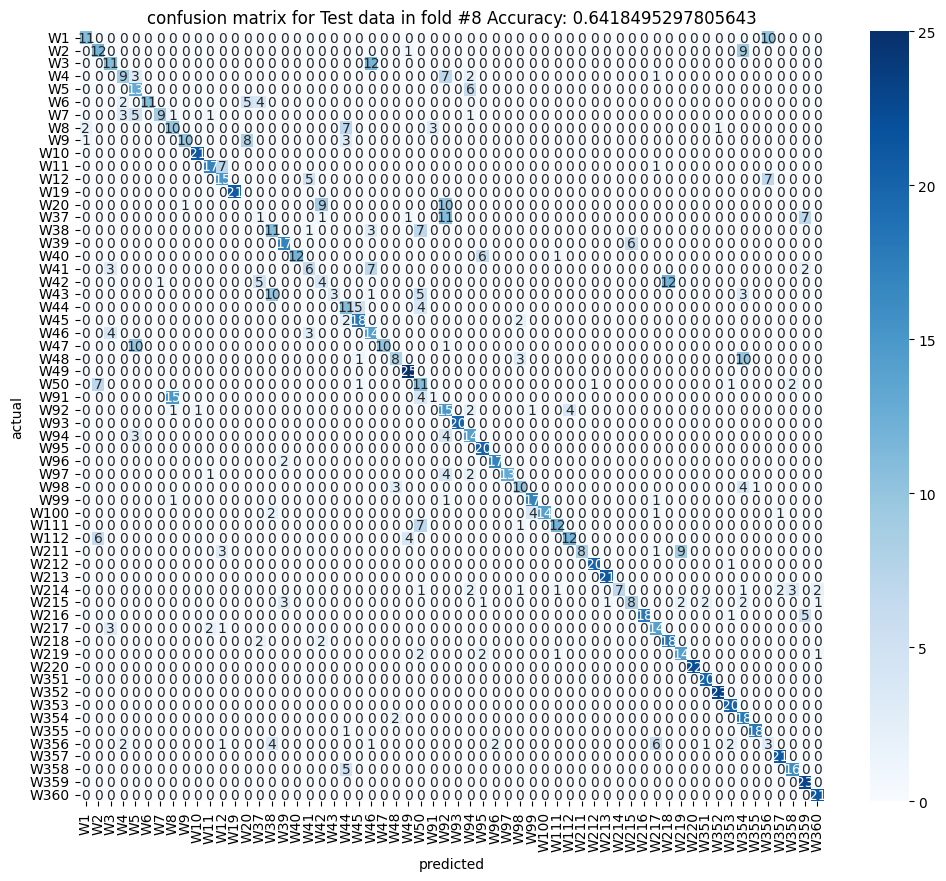

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conf_mat= conf_matrixes[bestTest-1]
print('test accuracies: ',test_accuracies, bestTest-1)
print ('validation accuracies: ',all_accuracies)
# average_conf_mat = np.mean(conf_matrixes, axis=0)
# for conf_matrix in conf_matrixes:
#     average_conf_mat +=  conf_matrix
# y_val_true_classes,y_val_pred_classes
ylabel =['W1','W2','W3','W4','W5','W6','W7','W8','W9','W10','W11','W12','W19','W20','W37','W38','W39','W40','W41','W42','W43','W44','W45','W46','W47','W48','W49','W50','W91','W92','W93','W94','W95','W96','W97','W98','W99','W100','W111','W112','W211','W212','W213','W214','W215','W216','W217','W218','W219','W220','W351','W352','W353','W354','W355','W356','W357','W358','W359','W360']
print(len(ylabel))
# ticklabels=np.unique(y_val_true_classes)
plt.figure(figsize=(12,10))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Blues',xticklabels=ylabel,yticklabels=ylabel)
plt.title(f'confusion matrix for Test data in fold #{bestTest} Accuracy: {test_accuracies[bestTest-1]}')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.show()
